# Notebook on Region Graphs


## Goals
By the end of this tutorial you will:

* [know what a region graph is](#What-is-a-Region-Graph?)
* know how to choose between region graphs for your circuit
* build circuits to **tractably** estimate a probability distribution over images[<sup>1</sup>](#fn1)

We will cover:

* High-level explanation of how to use region graphs
* Deep dive into region graphs (Advanced)


# How to build your circuit

In order to build a circuit, we need three main ingredients:

1. A **region graph**
2. A **parametrisation**
3. **folding**


## Why do we need these ingredients?

We need these ingredients becase we want to build **tractable/efficient** models that are **expressive**.

### 1. Region Graph

The structure of the region graph is what determines if inference can be efficient or not.
More specifically, we will introduce:

* RND
* QT
* QG


### 2. (Over)Parametrisation

Given a **region graph**, the simplest way to build a circuit is to associate a single input distribution unit per leaf
region, a single sum per inner region, and an single product unit per partition, and then connect them
following the RG structure.
If we parametrise a circuit simply, we do not get much expressive power.

### 3. Folding

If we naively compute a forward pass of a circuit, we need to resort to a lot of sparse computations.
But sparse compute is not compatible with GPUs.
However, in many case we can ``fold'' the computations into tensor operation via a process we call folding.
This operation does not affect the efficiency of the circuit in terms of big-oh notation, but it can significantly speed up inference empirically.
Note that folding is only a syntactic transformation of the circuit, i.e., it does not change the encoded function and
hence it preserves its expressiveness. 



[<sup id="fn1">1</sup>](#fn1-back)  This is not tractable for general neural network models



# Data Setup

As with the [previous tutorial](https://github.com/april-tools/cirkit/blob/main/notebooks/learning-a-circuit.ipynb), we will be working on the MNIST Dataset, so we begin by loading that:

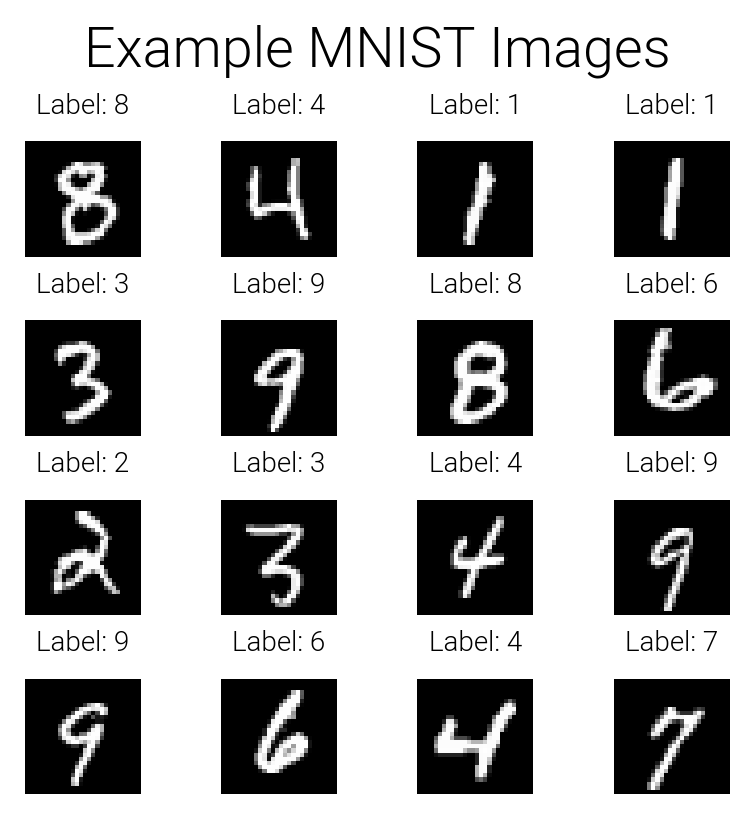

In [28]:
import matplotlib.pyplot as plt

from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

PIXEL_RANGE=255
# Store an example image
example_image = None

# Load the MNIST data set and data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    # Set pixel values in the [0-255] range
    transforms.Lambda(lambda x: (PIXEL_RANGE * x).long())
])

# Function to plot the first 9 images from the dataloader
def plot_sample_images(dataloader, gridsize=4):
    global example_image
    # Get the first batch of images and labels
    images, labels = next(iter(dataloader))
    
    example_image = images[0]
    images = images[:gridsize**2]
    
    # Create a 3x3 subplot
    fig, axes = plt.subplots(gridsize, gridsize, figsize=(8, 8))
    
    # Plot each image
    for i, ax in enumerate(axes.flat):
        # Convert the image to a 2D array (since MNIST images are 28x28 pixels)
        img = images[i].numpy().squeeze()

        # Display the image
        ax.imshow(img, cmap='gray')
        ax.axis('off')  # Turn off axis
        ax.set_title(f"Label: {labels[i].item()}", fontsize=20)
    
    # Adjust spacing between subplots
    fig.suptitle('Example MNIST Images')
    plt.tight_layout()
    plt.show()


data_train = datasets.MNIST('datasets', train=True, download=True, transform=transform)
data_test = datasets.MNIST('datasets', train=False, download=True, transform=transform)

# Instantiate the training and testing data loaders
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)

# Call the function to plot images
plot_sample_images(train_dataloader, gridsize=4)

# Regions Graphs: High Level


## What is a Region Graph?

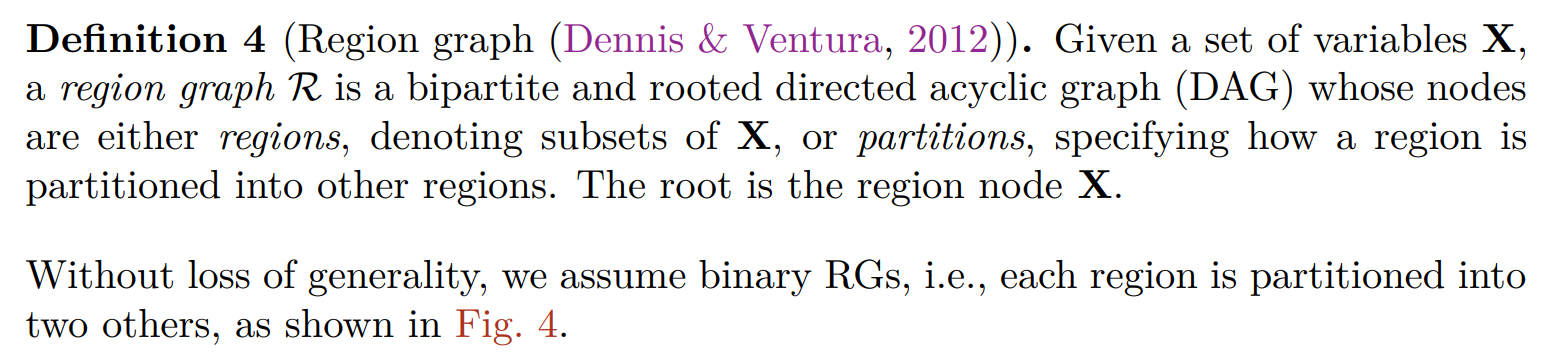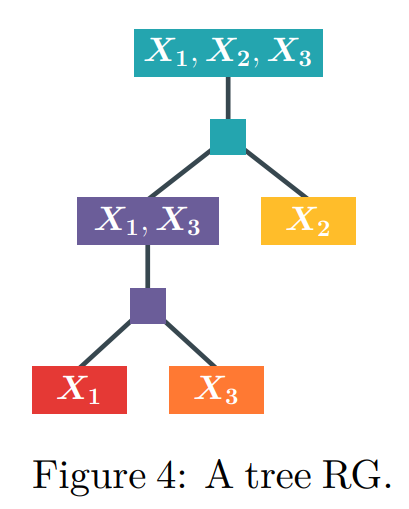

We begin with a high level overview of how to choose region graphs.
We begin where we left off in the [previous tutorial](https://github.com/april-tools/cirkit/blob/main/notebooks/learning-a-circuit.ipynb).
Recall we used:

```python
from cirkit.templates import circuit_templates

symbolic_circuit = circuit_templates.image_data(
    (1, 28, 28),                # The shape of MNIST image, i.e., (num_channels, image_height, image_width)
    # ----------------------------------------------------------------------------------------------------
    region_graph='quad-graph',  # Select the structure of the circuit to follow the QuadGraph region graph 
    # -----------------------------------------------------------------------------------------------------
    input_layer='categorical',  # Use Categorical distributions for the pixel values (0-255) as input layers
    num_input_units=64,         # Each input layer consists of 64 Categorical input units
    sum_product_layer='cp',     # Use CP sum-product layers, i.e., alternate dense sum layers and hadamard product layers
    num_sum_units=64,           # Each dense sum layer consists of 64 sum units
    sum_weight_param='softmax'  # Parameterize the weights of dense sum layers with 'softmax'
)
```

Here we dive into the `region_graph` line and explain the options we have.

# Region Graphs: Deep Dive

## Compute number of Random Variables

In [45]:
import numpy as np
# Compute number of random variables needed (one per pixel value)
img_shape = example_image.shape[1:]
n = np.prod(img_shape)

# Random Binary Tree

In [46]:
from cirkit.symbolic.circuit import Circuit
from cirkit.templates.region_graph import RandomBinaryTree
from cirkit.symbolic.layers import CategoricalLayer

# We can also specify depth and number of repetitions
# depth=None means maximum possible and we use one repetition for simplicity
rnd = RandomBinaryTree(n,
                       depth=None,
                       num_repetitions=1 # No overparametrisation
                       )

# Here is where Overparametrisation comes in
input_factory = lambda x, y, z: CategoricalLayer(scope=x,
                                                 num_categories=PIXEL_RANGE,
                                                 num_channels=1, # These are grayscale images
                                                 num_output_units=1 # No overparametrisation
                                                )
cc_rnd = Circuit.from_region_graph(rnd, input_factory=input_factory, sum_product='cp')

# Quad Tree

In [48]:
from cirkit.templates.region_graph import QuadTree

qt = QuadTree(img_shape)
cc_qt = Circuit.from_region_graph(qt, input_factory=input_factory, sum_product='cp')

# Quad Graph

In [49]:
from cirkit.templates.region_graph import QuadGraph

qg = QuadGraph(img_shape)
cc_qg = Circuit.from_region_graph(qt, input_factory=input_factory, sum_product='cp')

# Experiments: Comparision of Region Graphs

In [ ]:
# Fit model?

## Further reading

For more details on region graphs, parametrisations and folding, see Chapters 4 and 5 of [What is the Relationship between Tensor Factorizations
and Circuits ](https://arxiv.org/abs/2409.07953).
For the implementations, see the code for the supported [Region Graphs](https://github.com/andreasgrv/cirkit/blob/main/cirkit/templates/region_graph/algorithms.py).
